# Deep Linear Networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/dlns.ipynb)

Here, we repeat the experiments by [Jacot et al. (2022)](https://arxiv.org/abs/2106.15933), then [estimate SLT-derived invariants like the learning coefficient](https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py).

Currently, this only looks at the learning task behind figure 3 (not the MC loss behind figure 2).

A **deep linear network** (DLN) of length $L$ is a neural network with $L$ layers of widths $n_0, \dots, n_L$, that computes the transformation:

$$
\begin{align}
f: \mathbb{R}^{n_0} &\to \mathbb{R}^{n_L} \\
x &\mapsto W_L \cdots W_1 x =: A_\theta x,
\end{align}
$$

Parametrized by $\theta \in \mathbb{R}^P$, where $P = \sum_{l=1}^L n_{l-1} n_l$ is the number of parameters.

For convenience, we consider **rectangular networks**, or $(L, w)$-DLNs, with constant hidden width $w$ across all layers: $n_1 = \dots = n_{L-1} = w$.

## Hyperparameters

- $L$ is the number of layers
- $N=n_0$ is the input dimension
- $M=n_L$ is the output dimension
- $r$ is the rank of the "true" matrix / teacher $A^*$
- $w$ or $H$ is the hidden width (for rectangular networks).
- $\sigma$ is the teacher's output noise. By default, we use $\sigma=0$.


# Set-up

- For the definition of the model `DLN`, a `torch.nn.Module`, see `devinterp.zoo.dlns.model`.
- For the definition of the dataset `DLNDataset`, a `torch.utils.data.Dataset`, see `devinterp.zoo.dlns.dataset`.

In [ ]:
%pip install devinterp matplotlib seaborn

## Imports

In [1]:
import logging
import os
from typing import Callable, Dict, List, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

from devinterp.slt import estimate_learning_coeff
from devinterp.zoo.dlns.model import DLN
from devinterp.zoo.dlns.data import DLNDataset
from devinterp.optim.sgld import SGLD

logging.basicConfig(level=logging.INFO)

sns.set_palette("deep")
sns.set_style("whitegrid")

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))
DEVICE, NUM_CORES

(device(type='mps'), 1)

In [27]:
from pydantic import BaseModel
from dataclasses import dataclass


@dataclass
class Learner:
    config: "RectangularDLNConfig"
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]


class RectangularDLNConfig(BaseModel):
    teacher_matrix: torch.Tensor
    gamma: float = 1.1
    w: int = 100
    L: int = 4
    seed: int = 0
    noise_level: float = 1.0
    num_training_samples: int = 1024
    batch_size: int = 128
    num_steps: int = 10_000
    device: str = "cpu"
    lr: float = 1e-3
    momentum: float = 0.9
    weight_decay: float = 1e-3

    class Config:
        arbitrary_types_allowed = True

    def create_teacher(self):
        return DLN.from_matrix(self.teacher_matrix, L=1)

    def create_student(self):
        return DLN.make_rectangular(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            L=self.L,
            w=self.w,
            gamma=self.gamma,
        )

    def create_data(self, teacher: DLN):
        return DLNDataset.generate_split(
            teacher, self.num_training_samples, self.noise_level, self.seed
        )

    def create_learner(self, **kwargs):
        teacher = self.create_teacher()
        student = self.create_student()
        trainset, testset = self.create_data(teacher)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True
        )
        evals = make_evals(teacher_matrix, trainset, testset, self.device, **kwargs)
        optimizer = optim.SGD(
            student.parameters(),
            lr=self.lr,
            momentum=self.momentum,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, student, trainset, trainloader, optimizer, evals)
        return learner

    @property
    def input_dim(self):
        return self.teacher_matrix.shape[1]

    @property
    def output_dim(self):
        return self.teacher_matrix.shape[0]

    def model_dump(self, *args, **kwargs):
        dump = super().model_dump(*args, **kwargs)
        dump["teacher_matrix"] = self.teacher_matrix.tolist()

        return dump


def make_evals(
    teacher_matrix: torch.Tensor,
    trainset: DLNDataset,
    testset: DLNDataset,
    device: str,
    num_draws: int = 10,
    num_chains: int = 10,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    num_cores: int = NUM_CORES,
    repeats=5,
    lr=1e-4,
    **kwargs,
):
    teacher_matrix = teacher_matrix.to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    def eval_mse(model, loader):
        loss = 0
        count = 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            loss += F.mse_loss(model(x), y, reduction="sum").item()
            count += len(x)

        return loss / count

    def eval_progress(model: DLN):
        # Divide the first singular value by the first singular value of the teacher, and so on, then sum.
        # This needs a new name.
        singular_values = model.to_matrix().to("cpu").svd().S
        teacher_singular_values = teacher_matrix.to("cpu").svd().S
        missing_singular_values = teacher_singular_values == 0
        teacher_singular_values[missing_singular_values] = 1
        progress = singular_values / teacher_singular_values
        # Get rid of division by zero problems
        progress[progress == np.inf] = 0
        progress[progress == -np.inf] = 0
        progress[missing_singular_values] = 0

        return torch.sum(progress).item()

    def eval_matrix_properties(model: DLN):
        return {
            "rank": model.rank(atol=1e-1).item(),
            "ranks": [e.item() for e in model.ranks(atol=1e-1)],
            "grad_norm": model.grad_norm().item(),
            "nuc_norm": model.norm(p="nuc").item(),
            "nuc_norms": [e.item() for e in model.norms(p="nuc")],
        }

    def eval_rlct(model: DLN):
        model.to("cpu")
        optimizer_kwargs = dict(
            lr=lr, temperature="adaptive", num_samples=len(trainset), elasticity=1.0
        )
        optimizer_kwargs.update(kwargs)
        rlct = estimate_learning_coeff(
            model,
            loader=trainloader,
            criterion=F.mse_loss,
            sampling_method=SGLD,
            optimizer_kwargs=optimizer_kwargs,
            num_draws=num_draws,
            num_chains=num_chains,
            num_burnin_steps=num_burnin_steps,
            num_steps_bw_draws=num_steps_bw_draws,
            cores=num_cores,
            pbar=False,
            device=torch.device(device),
        )
        model.to(device)
        return rlct.item()

    def eval_rlct_repeated(model):
        results = {f"rlct/{i}": eval_rlct(model) for i in range(repeats)}
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results

    def evals(model):
        return {
            "mse/train": eval_mse(model, trainloader),
            "mse/test": eval_mse(model, testloader),
            "progress": eval_progress(model),
            **eval_matrix_properties(model),
            **eval_rlct_repeated(model),
        }

    return evals


teacher_matrix = 10.0 * torch.Tensor(np.diag([1, 2, 3, 4, 5])).detach()
config = RectangularDLNConfig(
    teacher_matrix=teacher_matrix,
    num_training_samples=1024,
    batch_size=128,
    num_steps=10_000,
    w=100,
    L=4,
    gamma=1.0,
    noise_level=0.0,
    device=str(DEVICE),
)

In [28]:
def train(learner):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []

    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(
        np.logspace(0, num_steps, 50).astype(int)
    )
    print(logging_steps)

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})
        # print(yaml.dump(evals[-1]))
        learner.model.train()

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = F.mse_loss(y_hat, y)
            loss.backward()
            learner.optimizer.step()

            if step in logging_steps:
                log(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)

    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)

    return evals_df

In [29]:
learner = config.create_learner()
df = train(learner)

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/Users/Jesse/Projects/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

360.03240966796875 359.0725476074219 1024
377.97052001953125 358.8642529296875 1024
350.07568359375 359.2868087768555 1024
390.4325256347656 359.3693817138672 1024
393.0035095214844 358.9573065185547 1024
358.0920104980469 358.1355020141602 1024
366.8106689453125 358.3508773803711 1024
383.2538757324219 358.24192138671873 1024
363.7852478027344 359.08920806884765 1024
358.7637634277344 359.3285925292969 1024
360.6317138671875 358.30552490234373 1024
327.6131896972656 357.87745513916013 1024
375.8529968261719 359.5629318237305 1024
341.26416015625 357.7024905395508 1024
386.77056884765625 358.7413525390625 1024
350.9520263671875 357.8472979736328 1024
357.619873046875 359.469973449707 1024
344.86822509765625 358.50466491699217 1024
356.6102294921875 358.71478271484375 1024
364.2963562011719 358.0619860839844 1024
57.44132614135742 60.53226928710937 1024
65.42871856689453 60.52813957214355 1024
57.7742919921875 60.777457809448244 1024
59.80428695678711 60.63253528594971 1024
59.896888732

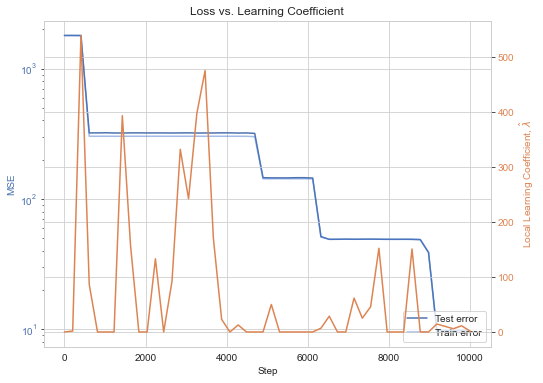

In [30]:
def plot_loss_vs_learning_coeff(
    df, figsize=(8, 6), title=None, ax: Optional[plt.Axes] = None, xlog=False, std=False
):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title if title else "Loss vs. Learning Coefficient")

    # Train error
    ax.plot(df.step, df["mse/test"], label="Test error", color=PRIMARY)
    ax.plot(df.step, df["mse/train"], label="Train error", color=PRIMARY_LIGHT, alpha=0.5)
    ax.set_yscale("log")
    ax.set_ylabel("MSE", color=PRIMARY)
    ax.tick_params(axis="y", labelcolor=PRIMARY)
    ax.legend(loc="lower right")

    # Learning coefficients
    axb = ax.twinx()
    rlcts = np.clip(df["rlct/mean"].to_numpy(), 0, None)
    axb.plot(df.step, rlcts, label="RLCTs", color=SECONDARY)
    axb.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    axb.tick_params(axis="y", labelcolor=SECONDARY)

    ax.set_xlabel("Step")

    if xlog:
        ax.set_xscale("log")

    if std:
        axb.fill_between(
            df.step,
            df["rlct/mean"] - df["rlct/std"],
            df["rlct/mean"] + df["rlct/std"],
            color=SECONDARY,
            alpha=0.3,
            label=r"Std $\hat\lambda$",
        )


def plot_all(df, xlog=False, figsize=(8, 6), title=None):
    L = len(df.ranks[0])

    # Figure 1: Loss and RLCTs
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    ax, ax2 = axes

    plot_loss_vs_learning_coeff(df, ax=ax, title=title, xlog=xlog)

    # Figure 2: Nuclear Norms
    ax2.set_title(title if title else "Nuclear Norms")
    ax2.set_xlabel("Step")
    if xlog:
        ax2.set_xscale("log")

    # Nuclear Norms
    for l in range(L):
        ax2.plot(df.step, [e[l] for e in df.nuc_norms], label=f"Nuclear Norm {l}")

    ax2.set_ylabel("Nuclear Norms")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


plot_loss_vs_learning_coeff(df, xlog=False)

In [ ]:
# Let's do some cherrypicking
dfs = []

for seed in range(5):
    config = RectangularDLNConfig(
        teacher_matrix=teacher_matrix,
        num_training_samples=1024,
        batch_size=128,
        num_steps=10_000,
        w=100,
        L=4,
        gamma=1.0,
        noise_level=0.0,
        device=str(DEVICE),
        seed=seed,
    )
    learner = config.create_learner(
        num_draws=10, num_chains=100, lr=1e-4, elasticity=1.0, repeats=5
    )
    df = train(learner)
    dfs.append(df)
    plot_loss_vs_learning_coeff(df, xlog=False)
    plt.show()

In [ ]:
for df in dfs:
    plot_loss_vs_learning_coeff(df, std=True)
    plt.show()

# Experiments

In [ ]:
# Defining all the teacher matrices


def run_experiment(teacher_matrix: torch.Tensor, seed=None, **kwargs):
    if seed:
        torch.manual_seed(seed)

    config = RectangularDLNConfig(teacher_matrix=teacher_matrix, **kwargs)
    learner = config.create_learner()
    df = train(learner)
    return df


# Set up the teacher matrices

rk5_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))

rk4_matrix = rk5_matrix.clone()
rk4_matrix[-1, -1] = 0

rk2_matrix = rk4_matrix.clone()
rk2_matrix[-2, -2] = 0
rk2_matrix[-3, -3] = 0

default_settings = dict(
    num_training_samples=1024,
    batch_size=128,
    num_steps=10_000,
    w=100,
    L=4,
    gamma=1.0,
    noise_level=0.0,
    device=str(DEVICE),
)

In [ ]:
results = {}
SEED = 0

for rk, teacher_matrix in zip([5, 4, 2], [rk5_matrix, rk4_matrix, rk2_matrix]):
    for noise_level in [0.0, 10.0]:
        name = f"rk{rk}_L4_w100_noise{noise_level}"
        results[name] = run_experiment(rk5_matrix, seed=SEED, **default_settings)
        plot_all(results[name], xlog=False, title=f"r={rk}, L=4, w=100, noise={noise_level}")

df = None

for rk, teacher_matrix in zip([5, 4, 2], [rk5_matrix, rk4_matrix, rk2_matrix]):
    for noise_level in [0.0, 10.0]:
        _df = pd.DataFrame(results[f"rk{rk}_L4_w100_noise{noise_level}"])
        _df["r"] = rk
        _df["noise_level"] = noise_level

        df = pd.concat([df, _df]) if df is not None else _df

df

# Recreate figure 5

In [ ]:
import matplotlib.pyplot as plt


def plot_grid(
    df,
    x_axis: str,
    z_axis: str,
    metrics: List[str],
    title: str,
    logscale: bool = True,
    inset=False,
    figsize=(10, 6),
):
    xs = df[x_axis].unique()
    zs = df[z_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(metrics), 3, figsize=figsize)
    fig.suptitle(title)

    fig.tight_layout()

    # Iterate through the unique gammas
    for i, x in enumerate(xs):
        for j, metric in enumerate(metrics):
            axes[j, 0].set_ylabel(metric)
            axes[-1, i].set_xlabel("# of steps")

            ax = axes[j, i]
            # Add an inset focusing on the first 2000 steps
            ax_inset = ax.inset_axes([0.65, 0.7, 0.3, 0.25])

            for k, z in enumerate(zs):
                data = df[(df[x_axis] == x) & (df[z_axis] == z)]
                color = colors[k]

                # Plot the training error against the number of steps
                ax.plot(data.step, data[metric], color=color, label=f"{z_axis}={z}")

                inset_data = data.loc[data.step < 2000]
                ax_inset.plot(inset_data.step, inset_data[metric], color=color)

            ax_inset.yaxis.set_visible(False)
            ax_inset.xaxis.set_visible(False)

            if logscale:
                ax_inset.set_yscale("log")
                ax.set_yscale("log")
                # ax_inset.set_xscale('log')
                # ax.set_xscale('log')

            if not inset:
                ax_inset.remove()

            ax.set_title(f"{x_axis}={x}")
            ax.legend(loc="lower left")

    plt.show()


plot_grid(
    df,
    "r",
    "noise_level",
    ["mse/train", "rlct/mean", "nuc_norm"],
    "Rank in [5, 4, 2], Noise Level in [0., 10.]",
)

In [ ]:
fig5_df = None

fig5_settings = dict(
    num_training_samples=1024,
    batch_size=128,
    num_steps=10_000,
    L=4,
    noise_level=0.0,
    device=str(DEVICE),
)

for gamma in [0.75, 1.0, 1.5]:
    # for w in [10, 100, 1000]:
    for w in [10, 100]:
        results = run_experiment(rk5_matrix, seed=SEED, w=w, gamma=gamma, **fig5_settings)
        _df = pd.DataFrame(results)
        _df["w"] = w
        _df["gamma"] = gamma
        fig5_df = pd.concat([fig5_df, _df]) if fig5_df is not None else _df
        plot_all(results, xlog=False, title=f"r=5, L=4, w={w}, noise=0, gamma={gamma}")

In [ ]:
plot_grid(
    fig5_df,
    "gamma",
    "w",
    ["mse/train", "rlct/mean", "nuc_norm"],
    "Gamma in [0.75, 1.0, 1.5], w in [10, 100, 1000]",
)
fig5_df